### Assignment 03

**Index No.**: 210504L  
**Github Profile**: [github.com/nadunnr](https://github.com/nadunnr)

#### 1. Manual Dense Network with Backpropagation for CIFAR-10

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 1.9065
Epoch 2/10, Loss: 1.6863
Epoch 3/10, Loss: 1.5995
Epoch 4/10, Loss: 1.5337
Epoch 5/10, Loss: 1.4796
Epoch 6/10, Loss: 1.4279
Epoch 7/10, Loss: 1.3841
Epoch 8/10, Loss: 1.3450
Epoch 9/10, Loss: 1.3100
Epoch 10/10, Loss: 1.2768


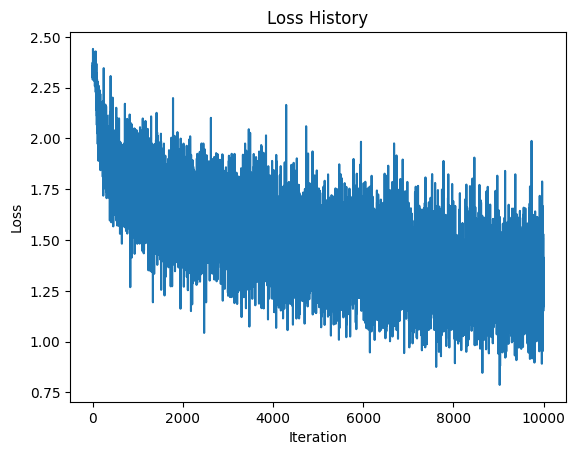

Training Accuracy: 57.25%
Test Accuracy: 46.91%


In [27]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

# 1. Dataloading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100  # Hidden layer size
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases
w1 = torch.randn(Din, H) * std
b1 = torch.zeros(H)
w2 = torch.randn(H, K) * std
b2 = torch.zeros(K)

# Hyperparameters
epochs = 10
lr = 0.005  # Learning rate
loss_history = []

# sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# CrossEntropy Loss
def CrossEntropyLoss(y_pred, y_true):
    smooth = 1e-9
    loss = -torch.sum(y_true * torch.log(y_pred + smooth)) / y_true.shape[0]
    return loss

# 3. Training Loop
# 3. Training Loop
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float()  # Convert labels to one-hot encoding

        # Forward pass with middle layer
        hidden = sigmoid(x_train.mm(w1) + b1)  # Middle layer with sigmoid activation
        y_pred = torch.softmax(hidden.mm(w2) + b2, dim=1) # Output layer activation

        # Loss calculation (CrossEntropy loss)
        loss = CrossEntropyLoss(y_pred, y_train_onehot)  # Cross-entropy loss
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = (y_pred - y_train_onehot) # Loss derivative
        dw2 = hidden.t().mm(dy_pred)
        db2 = dy_pred.sum(dim=0)

        # Backpropagation to hidden layer
        dhidden = dy_pred.mm(w2.t()) * (hidden * (1 - hidden))  # Derivative of sigmoid
        dw1 = x_train.t().mm(dhidden) 
        db1 = dhidden.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader):.4f}")

# 4. Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# 5. Calculate Accuracy
def calculate_accuracy(loader, w1, b1, w2, b2):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            N = inputs.shape[0]
            x = inputs.view(N, -1)

            # Forward pass
            z1 = x.mm(w1) + b1
            a1 = torch.sigmoid(z1)
            z2 = a1.mm(w2) + b2
            y_pred = torch.argmax(z2, dim=1)

            total += labels.size(0)
            correct += (y_pred == labels).sum().item()
    return 100 * correct / total

train_acc = calculate_accuracy(trainloader, w1, b1, w2, b2)
test_acc = calculate_accuracy(testloader, w1, b1, w2, b2)

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

#### 2. LeNet-5 network for MNIST using Pytorch

Epoch 1/10, Loss: 0.2393
Epoch 2/10, Loss: 0.0667
Epoch 3/10, Loss: 0.0485
Epoch 4/10, Loss: 0.0362
Epoch 5/10, Loss: 0.0298
Epoch 6/10, Loss: 0.0244
Epoch 7/10, Loss: 0.0205
Epoch 8/10, Loss: 0.0171
Epoch 9/10, Loss: 0.0163
Epoch 10/10, Loss: 0.0135


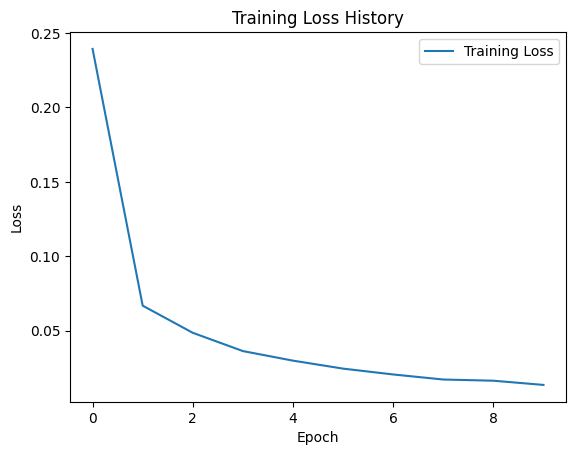

Training accuracy: 99.75%
Test accuracy: 98.99%


In [11]:
import torch
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
testset = datasets.MNIST('./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LeNet-5
class LeNet5(nn.Module):

    # network structure
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        '''
        One forward pass through the network.
        
        Args:
            x: input
        '''
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)

model = LeNet5().to(device)

# Training and evaluation
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses = []

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Record average loss for this epoch
    train_losses.append(running_loss / len(trainloader))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_losses[-1]:.4f}")

# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Calculate training accuracy
model.eval()
correct_train = sum((torch.max(model(inputs.to(device)), 1)[1] == labels.to(device)).sum().item()
                    for inputs, labels in trainloader)
train_accuracy = 100 * correct_train / len(trainloader.dataset)
print(f"Training accuracy: {train_accuracy:.2f}%")

# Calculate test accuracy
correct_test = sum((torch.max(model(inputs.to(device)), 1)[1] == labels.to(device)).sum().item()
                   for inputs, labels in testloader)
test_accuracy = 100 * correct_test / len(testloader.dataset)
print(f"Test accuracy: {test_accuracy:.2f}%")


#### 3. Transfer Learning ResNet-18

In [20]:
import os
import urllib.request
import zipfile

# Define the paths
dataset_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
dataset_dir = "data/"
zip_path = os.path.join(dataset_dir, "hymenoptera_data.zip")

# Create the directory if it doesn't exist
os.makedirs(dataset_dir, exist_ok=True)

# Download the dataset
print("Downloading Hymenoptera dataset...")
urllib.request.urlretrieve(dataset_url, zip_path)
print("Download complete!")

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)
print("Dataset extracted!")

# Clean up the zip file
os.remove(zip_path)
print("Hymenoptera dataset is ready at:", dataset_dir)

Download complete!
Dataset extracted!
Hymenoptera dataset is ready at: data/


In [21]:
#transfer learning on a pre-trained ResNet-18 model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

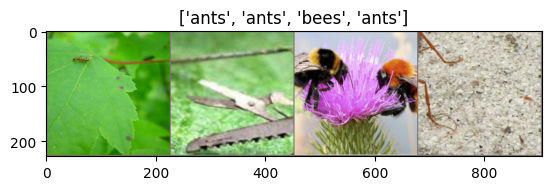

In [22]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [37]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

##### (a) Fine tuning the model

In [25]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6254 Acc: 0.6721
val Loss: 0.7416 Acc: 0.6928

Epoch 1/24
----------
train Loss: 0.9047 Acc: 0.7008
val Loss: 0.4710 Acc: 0.7908

Epoch 2/24
----------
train Loss: 0.6499 Acc: 0.7500
val Loss: 0.5068 Acc: 0.7843

Epoch 3/24
----------
train Loss: 0.5456 Acc: 0.7664
val Loss: 0.6359 Acc: 0.8235

Epoch 4/24
----------
train Loss: 0.8030 Acc: 0.7623
val Loss: 0.9245 Acc: 0.6732

Epoch 5/24
----------
train Loss: 0.5848 Acc: 0.7828
val Loss: 0.5252 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.7505 Acc: 0.7213
val Loss: 0.3388 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.2870 Acc: 0.8525
val Loss: 0.2648 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3687 Acc: 0.8443
val Loss: 0.2479 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.3819 Acc: 0.8115
val Loss: 0.2391 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.3647 Acc: 0.8443
val Loss: 0.2139 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3786 Acc: 0.8238
val Loss: 0.2430 Acc: 0.8954

Ep

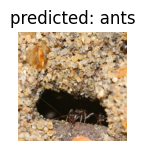

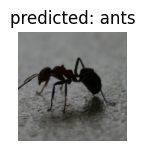

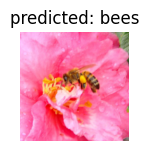

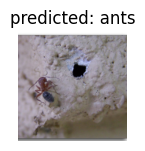

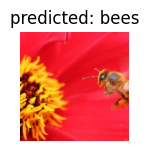

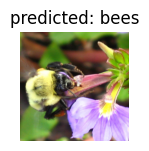

In [38]:
visualize_model(model_ft)

##### (b) Using model as feature extractor

- Since the requires_grad = False for resnet18 model back bone, parameters are not learnable. It works as a feature extractor.

In [30]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8673 Acc: 0.5820
val Loss: 0.3036 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.4794 Acc: 0.7910
val Loss: 0.3874 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.5695 Acc: 0.7541
val Loss: 0.1773 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4277 Acc: 0.8156
val Loss: 0.2050 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.5197 Acc: 0.8115
val Loss: 0.1782 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4769 Acc: 0.8115
val Loss: 0.1701 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.6592 Acc: 0.7336
val Loss: 0.2651 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4874 Acc: 0.7746
val Loss: 0.1631 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3222 Acc: 0.8689
val Loss: 0.1594 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3284 Acc: 0.8566
val Loss: 0.1742 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2488 Acc: 0.8934
val Loss: 0.1610 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3282 Acc: 0.8730
val Loss: 0.1690 Acc: 0.9346

Ep

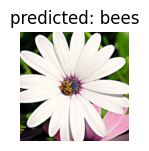

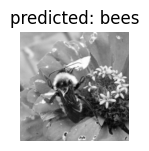

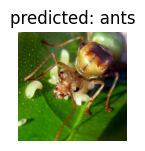

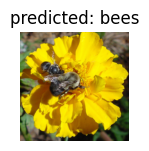

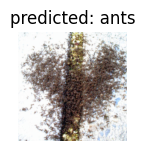

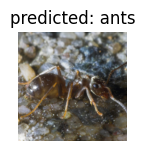

In [39]:
visualize_model(model_conv)

plt.ioff()
plt.show()